In [110]:
import numpy as np
import polars as pl
import sys, os
import datetime as dt
from sklearn.model_selection import TimeSeriesSplit
from pathlib import Path
from pybit.unified_trading import HTTP
import xgboost as xgb
from sklearn.model_selection import train_test_split
# Get the current working directory
current_dir = os.getcwd()

# Add the parent directory to sys.path
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

import matplotlib.pyplot as plt
import plotly.express as px
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.tsa.api import VAR
from scipy.stats import norm

print(os.getcwd())
import fin_utilities 
from algo_code.feature_engineering import *
cfg = fin_utilities.__cfg_reading("pred")


#td = TDClient(apikey=cfg['TWELVEDATA']['API'])  

PROJECT_DIR = eval(cfg['PROJECT_PATH'])
DATA_PATH   = PROJECT_DIR / cfg['DATA_FOLDER']

BYBIT_API_KEY = "5u0HfwB5UPJeiQo3WR"
BYBIT_SECRET_KEY = "hjFn5aEvyuVEZ1dnna6R4s1NS1vw3vZdJFIL"

plotme = False

/home/themanuello/Documents/repo/FinancialPython


In [118]:
df_orig = pl.read_parquet(DATA_PATH / "feature_engineering.parquet")

In [119]:
if plotme:
    fig = px.line(df_orig.select(pl.col(["date","close","symbol"])), x="date", y="close", color="symbol")
    fig.show()
    fig2 = px.line(df_orig.select(pl.col(["date","volume","symbol"])), x="date", y="volume", color="symbol")
    fig2.show()
    fig3 = px.line(df_orig.select(pl.col(["date","turnover","symbol"])), x="date", y="turnover", color="symbol")
    fig3.show()

In [120]:
df_orig.select(pl.col(["close","volume", "turnover"])).corr()

close,volume,turnover
f64,f64,f64
1.0,-0.095608,0.613766
-0.095608,1.0,0.014568
0.613766,0.014568,1.0


In [121]:
df = df_orig
print(df.shape)

(137718, 11)


## SCALO FEATURE

In [122]:
# Create a list to store the processed dataframes

# a seconda della scala che voglio utilizzare, cambio il suffisso
TYPE_SCALE_SUFFIXES = {
    "pct_change": "_pct_change",
    "z_score": "_z_score",
    "diff": "_diff",
}
type_scale = "pct_change"

type_scale_suffix = TYPE_SCALE_SUFFIXES[type_scale]
tgt_column = f"close{type_scale_suffix}"

processed_dfs = []

for symbol in df["symbol"].unique():
    # Filter the dataframe for the current symbol
    tmp_df = df.filter(pl.col("symbol") == symbol)    
    # Apply scale_features to the filtered dataframe
    tmp_df = scale_features(tmp_df, ["close", "volume", "turnover"], type_scale=type_scale, suffix=type_scale_suffix)
    # Append the processed dataframe to the list
    processed_dfs.append(tmp_df)

# Concatenate all processed dataframes
df = pl.concat(processed_dfs)

# Drop any null values that might have been introduced
df = df.drop_nulls()

# Display the first few rows of the updated dataframe
df.head()

timestamp,open,high,low,close,volume,turnover,date,symbol,long_signal,short_signal,close_pct_change,volume_pct_change,turnover_pct_change
i64,f64,f64,f64,f64,f64,f64,datetime[μs],str,i8,i8,f64,f64,f64
1672531200000,9.98,10.02,9.93,9.99,40461.577,403719.27764,2023-01-01 00:00:00,"""SOL""",0,-1,0.001002,0.343349,0.345482
1672534800000,9.99,10.07,9.98,10.03,23317.783,234021.19925,2023-01-01 01:00:00,"""SOL""",0,-1,0.004004,-0.423706,-0.420337
1672538400000,10.03,10.08,10.0,10.02,17189.969,172544.99205,2023-01-01 02:00:00,"""SOL""",0,-1,-0.000997,-0.262796,-0.262695
1672542000000,10.02,10.02,9.91,9.97,20577.751,204993.38156,2023-01-01 03:00:00,"""SOL""",0,-1,-0.00499,0.197079,0.188058
1672545600000,9.97,9.99,9.82,9.85,25137.24,248727.05075,2023-01-01 04:00:00,"""SOL""",0,0,-0.012036,0.221574,0.213342


In [123]:
if plotme:
    x = "date"
    fig = px.line(df.select(pl.col([x,f"close{type_scale_suffix}", "symbol"])), x=x, y=f"close{type_scale_suffix}", color="symbol", height=400)
    fig.show()
    fig2 = px.line(df.select(pl.col([x,f"volume{type_scale_suffix}", "symbol"])), x=x, y=f"volume{type_scale_suffix}", color="symbol", height=400)
    fig2.show()
    fig3 = px.line(df.select(pl.col([x,f"turnover{type_scale_suffix}", "symbol"])), x=x, y=f"turnover{type_scale_suffix}", color="symbol", height=400)
    fig3.show()

In [124]:
if plotme:
    plot_histogram(df, "ETH", f"close{type_scale_suffix}")
    plot_histogram(df, "ETH", f"volume{type_scale_suffix}")

In [125]:
# PER IL CALCOLO DI ACF/PACF OCCORRE DROPPARE I NULL

lags_pacf = calculate_all_pacfs(df, f"close{type_scale_suffix}", 200, alpha=.4)
lags_acf = calculate_all_acfs(df, f"close{type_scale_suffix}", 200, alpha=.4)

common_lags = list(set(common_lags_by_symbol(lags_acf)).intersection(set(common_lags_by_symbol(lags_pacf))))
print(common_lags)

[1, 193, 23]


# Creo Feature

In [126]:
moving_averages_list = [13, 50, 100, 200]
on_cols = [f"close{type_scale_suffix}","close"]

# bisogn
df = calculate_rolling_avgs_by_symbol(df,moving_averages_list,on_cols)
df = df.drop_nulls()
df = extract_date_features(df, "date")
df.head(5)


timestamp,open,high,low,close,volume,turnover,date,symbol,long_signal,short_signal,close_pct_change,volume_pct_change,turnover_pct_change,SMA_close_pct_change_13,SMA_close_13,SMA_close_pct_change_50,SMA_close_50,SMA_close_pct_change_100,SMA_close_100,SMA_close_pct_change_200,SMA_close_200,dow,month,hour
i64,f64,f64,f64,f64,f64,f64,datetime[μs],str,i8,i8,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i8,i8,i8
1673247600000,16.01,16.53,16.01,16.36,87993.35,1.4296e6,2023-01-09 07:00:00,"""SOL""",0,0,0.021861,0.333812,0.34629,0.014777,15.100769,0.004208,13.7952,0.002195,13.5234,0.002569,12.6031,1,1,7
1673251200000,16.36,16.67,16.1,16.11,52283.57,853343.79442,2023-01-09 08:00:00,"""SOL""",1,0,-0.015281,-0.405824,-0.40308,0.013601,15.297692,0.004037,13.8528,0.001952,13.5511,0.002488,12.6337,1,1,8
1673254800000,16.11,16.38,16.1,16.34,27248.757,443300.34847,2023-01-09 09:00:00,"""SOL""",0,0,0.014277,-0.478828,-0.480514,0.013564,15.496923,0.004232,13.9138,0.002117,13.5814,0.002539,12.66525,1,1,9
1673258400000,16.34,16.59,16.28,16.41,34800.199,572253.42932,2023-01-09 10:00:00,"""SOL""",0,0,0.004284,0.27713,0.290893,0.014061,15.703846,0.004498,13.9786,0.00225,13.6136,0.002565,12.6972,1,1,10
1673262000000,16.41,16.81,16.31,16.36,93775.937,1.5522e6,2023-01-09 11:00:00,"""SOL""",0,0,-0.003047,1.694695,1.712429,0.013939,15.908462,0.004361,14.0414,0.002182,13.6448,0.002575,12.72915,1,1,11


In [127]:
with pl.Config(set_tbl_rows=2):
    display(df.with_columns(scale_features(df, ["SMA_close_13"])[f"SMA_close{type_scale_suffix}_13"].alias(f"SMA_close{type_scale_suffix}_13_after_scaling")).head(25))

timestamp,open,high,low,close,volume,turnover,date,symbol,long_signal,short_signal,close_pct_change,volume_pct_change,turnover_pct_change,SMA_close_pct_change_13,SMA_close_13,SMA_close_pct_change_50,SMA_close_50,SMA_close_pct_change_100,SMA_close_100,SMA_close_pct_change_200,SMA_close_200,dow,month,hour,SMA_close_pct_change_13_after_scaling
i64,f64,f64,f64,f64,f64,f64,datetime[μs],str,i8,i8,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i8,i8,i8,f64
1673247600000,16.01,16.53,16.01,16.36,87993.35,1.4296e6,2023-01-09 07:00:00,"""SOL""",0,0,0.021861,0.333812,0.34629,0.014777,15.100769,0.004208,13.7952,0.002195,13.5234,0.002569,12.6031,1,1,7,0.014777
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1673334000000,16.06,16.11,15.88,15.89,28364.284,452634.55593,2023-01-10 07:00:00,"""SOL""",1,0,-0.010585,-0.236237,-0.243011,-0.00271,16.181538,0.003681,15.2936,0.001934,14.2545,0.00243,13.37485,2,1,7,-0.00271


In [128]:
df = df.with_columns(
    pl.when(pl.col("open") > pl.col("close")).then(1).otherwise(0).alias("green_candle"),
    pl.when(pl.col("open") <= pl.col("close")).then(1).otherwise(0).alias("red_candle")
)
# cumulative count of consecutive green candles set to True:

df = df.with_columns(
    pl.when(pl.col("green_candle") == 1)
    .then(
        pl.col("green_candle").cum_sum().over(
            (pl.col("green_candle") != pl.col("green_candle").shift(1)).cum_sum()
        ) - 1
    )
    .otherwise(0)
    .alias("cons_green_candles"),
    pl.when(pl.col("red_candle") == 1)
    .then(
        pl.col("red_candle").cum_sum().over(
            (pl.col("red_candle") != pl.col("red_candle").shift(1)).cum_sum()
        ) - 1
    )
    .otherwise(0)
    .alias("cons_red_candles")
)

In [129]:
other_lags = [1, 2, 3, 4, 6, 12, 72]
all_lags = list(set(common_lags).union(set(other_lags)))
df = calculate_rsi_by_symbol(df, window=14)
df = calculate_macd_by_symbol(df)
df = calculate_bollinger_bands_by_symbol(df)
df = scale_features(df, ["upper_band", "lower_band"])
df = create_lagged_features_by_symbol(df, f"close{type_scale_suffix}", significant_lags=all_lags)
df = df.drop_nulls()
df.head()

timestamp,open,high,low,close,volume,turnover,date,symbol,long_signal,short_signal,close_pct_change,volume_pct_change,turnover_pct_change,SMA_close_pct_change_13,SMA_close_13,SMA_close_pct_change_50,SMA_close_50,SMA_close_pct_change_100,SMA_close_100,SMA_close_pct_change_200,SMA_close_200,dow,month,hour,green_candle,red_candle,cons_green_candles,cons_red_candles,RSI_14,ema_short,ema_long,MACD,signal_line,macd_histogram,sma,std_dev,upper_band,lower_band,upper_band_pct_change,lower_band_pct_change,close_pct_change_lag_1,close_pct_change_lag_193,close_pct_change_lag_2,close_pct_change_lag_3,close_pct_change_lag_4,close_pct_change_lag_6,close_pct_change_lag_72,close_pct_change_lag_12,close_pct_change_lag_23
i64,f64,f64,f64,f64,f64,f64,datetime[μs],str,i8,i8,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i8,i8,i8,i32,i32,i32,i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1673942400000,23.41,23.68,23.37,23.67,15522.518,365039.35229,2023-01-17 08:00:00,"""SOL""",0,-1,0.011106,-0.391288,-0.389151,0.00029,23.446154,0.001049,23.3032,0.003548,21.9467,0.002445,19.07985,2,1,8,0,1,0,1,56.5,23.438028,23.388865,0.049163,0.046626,0.0,23.396,0.213715,23.61,23.18,0.001272,0.000432,0.00214,0.021861,-0.008068,0.004264,0.010776,0.001293,0.003396,0.000424,0.012998
1673946000000,23.67,23.76,23.47,23.62,17448.485,411700.31441,2023-01-17 09:00:00,"""SOL""",0,-1,-0.002112,0.124076,0.127824,0.000095,23.447692,0.000936,23.3228,0.00361,22.0148,0.00226,19.1206,2,1,9,1,0,0,0,55.25,23.466024,23.405986,0.060038,0.049309,0.01,23.4145,0.216275,23.63,23.2,0.000847,0.000863,0.011106,-0.015281,0.00214,-0.008068,0.004264,-0.001291,-0.044839,0.005085,0.001283
1673949600000,23.62,23.69,23.43,23.44,13251.735,311649.85089,2023-01-17 10:00:00,"""SOL""",1,0,-0.007621,-0.240522,-0.243018,-0.000882,23.426154,0.001217,23.3486,0.003409,22.079,0.002057,19.1579,2,1,10,1,0,1,0,50.89,23.46202,23.408506,0.053515,0.05015,0.0,23.432,0.203066,23.64,23.23,0.000423,0.001293,-0.002112,0.014277,0.011106,0.00214,-0.008068,0.010776,-0.022143,-0.001686,-0.001282
1673953200000,23.44,23.98,23.41,23.76,51272.444,1.2189e6,2023-01-17 11:00:00,"""SOL""",0,-1,0.013652,2.869112,2.910964,0.000298,23.432308,0.001038,23.3708,0.003622,22.1477,0.002107,19.1965,2,1,11,0,1,0,0,57.34,23.507863,23.434542,0.073321,0.054784,0.02,23.465,0.200037,23.67,23.26,0.001269,0.001291,-0.007621,0.004284,-0.002112,0.011106,0.00214,0.004264,0.01404,-0.003378,-0.005988
1673956800000,23.76,23.85,23.47,23.57,31180.919,737149.7996,2023-01-17 12:00:00,"""SOL""",0,0,-0.007997,-0.391858,-0.39521,-0.000057,23.43,0.000843,23.3884,0.003512,22.214,0.002008,19.2332,2,1,12,1,0,0,0,52.9,23.517423,23.444576,0.072847,0.058397,0.01,23.4865,0.186609,23.67,23.3,0.0,0.00172,0.013652,-0.003047,-0.007621,-0.002112,0.011106,-0.008068,0.006253,-0.019915,0.00043


In [130]:
pippo = df.drop_nulls()
pippo.group_by("symbol").count()

/tmp/ipykernel_67528/3893138174.py:2: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  pippo.group_by("symbol").count()


symbol,count
str,u32
"""ATOM""",14908
"""TRX""",14908
"""BTC""",14908
"""ADA""",14908
"""ETH""",14908
"""XRP""",14908
"""LTC""",14908
"""SOL""",14908
"""DOGE""",14908


In [131]:
symbols_list = [
    "ETH", "BTC", "SOL",
    "XRP", "DOGE", "TRX",
    "ADA", "LTC", "ATOM"
]

symbol_encoding = {
    symbol: i for i, symbol in enumerate(symbols_list)
}

#symbol_encoding = {symbol: i for i, symbol in enumerate(df["symbol"].unique())}

df = df.with_columns(
    pl.col("symbol").replace(symbol_encoding).cast(pl.Int32).alias("symbol_encoded")
)
df.head()

timestamp,open,high,low,close,volume,turnover,date,symbol,long_signal,short_signal,close_pct_change,volume_pct_change,turnover_pct_change,SMA_close_pct_change_13,SMA_close_13,SMA_close_pct_change_50,SMA_close_50,SMA_close_pct_change_100,SMA_close_100,SMA_close_pct_change_200,SMA_close_200,dow,month,hour,green_candle,red_candle,cons_green_candles,cons_red_candles,RSI_14,ema_short,ema_long,MACD,signal_line,macd_histogram,sma,std_dev,upper_band,lower_band,upper_band_pct_change,lower_band_pct_change,close_pct_change_lag_1,close_pct_change_lag_193,close_pct_change_lag_2,close_pct_change_lag_3,close_pct_change_lag_4,close_pct_change_lag_6,close_pct_change_lag_72,close_pct_change_lag_12,close_pct_change_lag_23,symbol_encoded
i64,f64,f64,f64,f64,f64,f64,datetime[μs],str,i8,i8,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i8,i8,i8,i32,i32,i32,i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i32
1673942400000,23.41,23.68,23.37,23.67,15522.518,365039.35229,2023-01-17 08:00:00,"""SOL""",0,-1,0.011106,-0.391288,-0.389151,0.00029,23.446154,0.001049,23.3032,0.003548,21.9467,0.002445,19.07985,2,1,8,0,1,0,1,56.5,23.438028,23.388865,0.049163,0.046626,0.0,23.396,0.213715,23.61,23.18,0.001272,0.000432,0.00214,0.021861,-0.008068,0.004264,0.010776,0.001293,0.003396,0.000424,0.012998,2
1673946000000,23.67,23.76,23.47,23.62,17448.485,411700.31441,2023-01-17 09:00:00,"""SOL""",0,-1,-0.002112,0.124076,0.127824,0.000095,23.447692,0.000936,23.3228,0.00361,22.0148,0.00226,19.1206,2,1,9,1,0,0,0,55.25,23.466024,23.405986,0.060038,0.049309,0.01,23.4145,0.216275,23.63,23.2,0.000847,0.000863,0.011106,-0.015281,0.00214,-0.008068,0.004264,-0.001291,-0.044839,0.005085,0.001283,2
1673949600000,23.62,23.69,23.43,23.44,13251.735,311649.85089,2023-01-17 10:00:00,"""SOL""",1,0,-0.007621,-0.240522,-0.243018,-0.000882,23.426154,0.001217,23.3486,0.003409,22.079,0.002057,19.1579,2,1,10,1,0,1,0,50.89,23.46202,23.408506,0.053515,0.05015,0.0,23.432,0.203066,23.64,23.23,0.000423,0.001293,-0.002112,0.014277,0.011106,0.00214,-0.008068,0.010776,-0.022143,-0.001686,-0.001282,2
1673953200000,23.44,23.98,23.41,23.76,51272.444,1.2189e6,2023-01-17 11:00:00,"""SOL""",0,-1,0.013652,2.869112,2.910964,0.000298,23.432308,0.001038,23.3708,0.003622,22.1477,0.002107,19.1965,2,1,11,0,1,0,0,57.34,23.507863,23.434542,0.073321,0.054784,0.02,23.465,0.200037,23.67,23.26,0.001269,0.001291,-0.007621,0.004284,-0.002112,0.011106,0.00214,0.004264,0.01404,-0.003378,-0.005988,2
1673956800000,23.76,23.85,23.47,23.57,31180.919,737149.7996,2023-01-17 12:00:00,"""SOL""",0,0,-0.007997,-0.391858,-0.39521,-0.000057,23.43,0.000843,23.3884,0.003512,22.214,0.002008,19.2332,2,1,12,1,0,0,0,52.9,23.517423,23.444576,0.072847,0.058397,0.01,23.4865,0.186609,23.67,23.3,0.0,0.00172,0.013652,-0.003047,-0.007621,-0.002112,0.011106,-0.008068,0.006253,-0.019915,0.00043,2


# TRAIN

In [47]:
FEATURES = [col for col in df.columns if "pct_change" in col] \
    + ["dow","hour", "cons_green_candles", "cons_red_candles", "RSI_14", "macd_histogram"] \
    + ["symbol_encoded"]
print(FEATURES)

['close_pct_change', 'volume_pct_change', 'turnover_pct_change', 'SMA_close_pct_change_13', 'SMA_close_pct_change_50', 'SMA_close_pct_change_100', 'SMA_close_pct_change_200', 'upper_band_pct_change', 'lower_band_pct_change', 'close_pct_change_lag_1', 'close_pct_change_lag_193', 'close_pct_change_lag_23', 'dow', 'hour', 'cons_green_candles', 'cons_red_candles', 'RSI_14', 'macd_histogram', 'symbol_encoded']


In [ ]:
tscv = TimeSeriesSplit(n_splits=15, test_size=100)
p = {  
    'eval_metric':'auc',
    'tree_method':'hist',
    # 'lambda':5,
    #'gamma':2,
    'max_depth':5,
    # 'scale_pos_weight':2,
    'objective':'binary:logistic',
    'subsample': .8,
    # 'colsample_bytree': .9,
    'min_child_weight':1,
    'eta':0.02,
    'n_estimators':2000
}


def polars_time_series_cross_val(df: pl.DataFrame, target_var: str, n_splits: int = 5):
    tscv = TimeSeriesSplit(n_splits=n_splits, test_size=720)
    model = xgb.XGBClassifier(**p)  # Set optimal hyperparameters here

    # Cross-validation to find the best hyperparameters
    for train_index, test_index in tscv.split(df):
        train_data = df.slice(train_index[0], len(train_index))
        test_data = df.slice(test_index[0], len(test_index))
        
        # Splitting features and labels
        train_features, train_labels = split_target_features(train_data, target_var=target_var)
        val_features, val_labels = split_target_features(test_data, target_var=target_var)

        # Fit model (you can include hyperparameter tuning here)
        model.fit(train_features.to_pandas(), train_labels.to_pandas(), 
                  eval_set=[(train_features.to_pandas(), train_labels.to_pandas()), 
                            (val_features.to_pandas(), val_labels.to_pandas())], 
                  verbose=500)
    
    # This loop is only for cross-validation; the model will be re-trained below
    return model

# Final training using the entire dataset
def train_final_model(df: pl.DataFrame, target_var: str):
    model = xgb.XGBClassifier(**p)  # Set optimal hyperparameters here
    features, labels = split_target_features(df, target_var=target_var)
    # Train the final model on the entire dataset
    model.fit(features.to_pandas(), labels.to_pandas(), verbose=1)
    return model

# Usage
# Run cross-validation to tune hyperparameters
cv_model = polars_time_series_cross_val(df.select(FEATURES + ["long_signal"]), target_var='long_signal', n_splits=5)

print("Final Train")
# Train the final model using the entire dataset
final_model = train_final_model(df.select(FEATURES + ["long_signal"]), target_var='long_signal')

In [ ]:
model = xgb.XGBClassifier(**p)  # Set optimal hyperparameters here
features, labels = split_target_features(df.select(FEATURES + ["long_signal"]), target_var='long_signal')
# Train the final model on the entire dataset
model.fit(features.to_pandas(), labels.to_pandas(), verbose=True)
model.get_num_boosting_rounds()

2000

In [ ]:
y_hat = model.predict_proba(features.to_pandas())[:,1]

In [205]:
from sklearn.metrics import roc_auc_score
roc_auc_score(labels.to_pandas(),y_hat)

np.float64(0.839297564482169)

## PROVO AD AGGIUNGERE DATI DA S&P E NASDAQ

In [132]:
import yfinance as yf


# Usage
start_date = dt.datetime(2022, 12, 28)
print(start_date)
end_date = dt.datetime.now()
print(end_date)
data_sp = get_all_data(start_date, end_date)
data_sp = data_sp.with_columns(
    pl.col("date").dt.truncate("1h").dt.replace_time_zone(None).dt.cast_time_unit("us").alias("date"),
    pl.col("SP500").fill_null(strategy="forward").alias("SP500"),
    pl.col("NASDAQ").fill_null(strategy="forward").alias("NASDAQ"),
).sort("date")
data_sp = scale_features(data_sp, ["SP500", "NASDAQ"], type_scale="pct_change", suffix="_pct_change")
data_sp = data_sp.drop_nulls()

data_vix = get_vix_data(start_date, end_date)
data_vix = data_vix.with_columns(
    pl.col("date").dt.truncate("1h").dt.replace_time_zone(None).dt.cast_time_unit("us").alias("date"),
    pl.col("VIX").fill_null(strategy="forward").alias("VIX")
).sort("date")
data_vix = scale_features(data_vix, ["VIX"], type_scale="pct_change", suffix="_pct_change")

data_usd = get_stock_data("DX-Y.NYB", start_date, end_date)
data_usd = data_usd.with_columns(
    pl.col("date").dt.truncate("1h").dt.convert_time_zone("UTC").dt.replace_time_zone(None).dt.cast_time_unit("us").alias("date"),
    pl.col("Adj Close").fill_null(strategy="forward").alias("DXY")
).sort("date")
data_usd = scale_features(data_usd, ["DXY"], type_scale="pct_change", suffix="_pct_change")


[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  1 of 1 completed

2022-12-28 00:00:00
2024-10-07 22:41:19.445516



[*********************100%***********************]  1 of 1 completed


In [71]:
#Search for data series
#fred.search('potential gdp').T

In [133]:
all_dates = pl.DataFrame(
    pl.datetime_range(
        start_date,
        end_date,
        dt.timedelta(hours=1),
        time_unit="us",
        eager=True,
    ).alias("date")
)
data = all_dates.join(data_sp, on="date", how="left").with_columns(
    pl.col("SP500_pct_change").fill_null(strategy="forward"),
    pl.col("NASDAQ_pct_change").fill_null(strategy="forward"),
)
data = data.join(data_vix, on="date", how="left").with_columns(
    pl.col("VIX_pct_change").fill_null(strategy="forward"),
).sort("date")
data = data.join(data_usd, on="date", how="left").with_columns(
    pl.col("DXY_pct_change").fill_null(strategy="forward"),
).sort("date")

# shifto perche suppongo che l'ora prima influenzi i dati crypto dell'ora sucessiva
data = data.with_columns(
    pl.col("SP500_pct_change").shift().alias("SP500_pct_change"),
    pl.col("NASDAQ_pct_change").shift().alias("NASDAQ_pct_change"),
    pl.col("VIX_pct_change").shift().alias("VIX_pct_change"), 
    pl.col("DXY_pct_change").shift().alias("DXY_pct_change"), 
)

data = data[["date","SP500_pct_change","NASDAQ_pct_change","VIX_pct_change", "DXY_pct_change"]].drop_nulls()
data.tail(5)

date,SP500_pct_change,NASDAQ_pct_change,VIX_pct_change,DXY_pct_change
datetime[μs],f64,f64,f64,f64
2024-10-07 18:00:00,0.00162,0.00179,0.030059,0.000146
2024-10-07 19:00:00,0.00162,0.00179,0.030059,0.001133
2024-10-07 20:00:00,0.00162,0.00179,0.030059,-0.0004
2024-10-07 21:00:00,0.00162,0.00179,0.030059,-0.000039
2024-10-07 22:00:00,0.00162,0.00179,0.030059,-0.000039


In [134]:
df_merged = df.join(data, on="date", how="left")
df_merged.tail(5)

timestamp,open,high,low,close,volume,turnover,date,symbol,long_signal,short_signal,close_pct_change,volume_pct_change,turnover_pct_change,SMA_close_pct_change_13,SMA_close_13,SMA_close_pct_change_50,SMA_close_50,SMA_close_pct_change_100,SMA_close_100,SMA_close_pct_change_200,SMA_close_200,dow,month,hour,green_candle,red_candle,cons_green_candles,cons_red_candles,RSI_14,ema_short,ema_long,MACD,signal_line,macd_histogram,sma,std_dev,upper_band,lower_band,upper_band_pct_change,lower_band_pct_change,close_pct_change_lag_1,close_pct_change_lag_193,close_pct_change_lag_2,close_pct_change_lag_3,close_pct_change_lag_4,close_pct_change_lag_6,close_pct_change_lag_72,close_pct_change_lag_12,close_pct_change_lag_23,symbol_encoded,SP500_pct_change,NASDAQ_pct_change,VIX_pct_change,DXY_pct_change
i64,f64,f64,f64,f64,f64,f64,datetime[μs],str,i8,i8,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i8,i8,i8,i32,i32,i32,i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i32,f64,f64,f64,f64
1727593200000,0.12696,0.12736,0.12587,0.12596,1.1660e7,1.4748e6,2024-09-29 07:00:00,"""DOGE""",0,0,-0.007876,-0.194109,-0.199284,-0.002704,0.128656,0.000673,0.125926,0.001348,0.119372,0.000916,0.113457,7,9,7,1,0,4,0,44.7,0.127986,0.127318,0.000668,0.001192,-0.0,0.12851,0.002009,0.13,0.13,0.0,0.0,-0.005951,0.002959,-0.008847,-0.004481,-0.002927,0.011111,0.001766,-0.002835,-0.001642,4,-0.000792,-0.000344,0.008918,0.00002
1727596800000,0.12596,0.1268,0.12559,0.12626,9925707.5,1.2534e6,2024-09-29 08:00:00,"""DOGE""",0,0,0.002382,-0.148719,-0.150112,-0.002302,0.128358,0.000467,0.125978,0.001453,0.119538,0.000945,0.113563,7,9,8,0,1,0,0,46.04,0.127721,0.12724,0.000481,0.00105,-0.0,0.128653,0.001721,0.13,0.13,0.0,0.0,-0.007876,0.004093,-0.005951,-0.008847,-0.004481,0.004643,0.002909,0.002997,0.005673,4,-0.000792,-0.000344,0.008918,0.00002
1727600400000,0.12626,0.12741,0.12623,0.12664,8530702.8,1.0827e6,2024-09-29 09:00:00,"""DOGE""",0,0,0.00301,-0.140545,-0.136167,-0.002301,0.12806,0.000648,0.126052,0.001481,0.119707,0.001005,0.113675,7,9,9,0,1,0,1,47.76,0.127554,0.127195,0.000359,0.000912,-0.0,0.128781,0.00145,0.13,0.13,0.0,0.0,0.002382,0.003507,-0.007876,-0.005951,-0.008847,-0.002927,-0.002373,-0.010343,0.009892,4,-0.000792,-0.000344,0.008918,0.00002
1727604000000,0.12664,0.12713,0.12574,0.12712,8.583477e6,1.0856e6,2024-09-29 10:00:00,"""DOGE""",0,0,0.00379,0.006186,0.002685,-0.001214,0.127902,0.000625,0.126124,0.001602,0.11989,0.000997,0.113786,7,9,10,0,1,0,2,49.94,0.127488,0.12719,0.000298,0.000789,-0.0,0.128625,0.001453,0.13,0.13,0.0,0.0,0.00301,0.005573,0.002382,-0.007876,-0.005951,-0.004481,0.01304,-0.002477,0.010929,4,-0.000792,-0.000344,0.008918,0.00002
1727607600000,0.12712,0.12744,0.12659,0.127,4731543.9,601139.453446,2024-09-29 11:00:00,"""DOGE""",0,0,-0.000944,-0.448761,-0.446272,-0.001096,0.12776,0.000483,0.126178,0.001577,0.12007,0.00099,0.113897,7,9,11,1,0,0,0,49.39,0.127413,0.127176,0.000237,0.000678,-0.0,0.128425,0.001385,0.13,0.13,0.0,0.0,0.00379,-0.004603,0.00301,0.002382,-0.007876,-0.008847,-0.01148,-0.005976,-0.011851,4,-0.000792,-0.000344,0.008918,0.00002


In [135]:
assert len(df_merged.filter(pl.col("SP500_pct_change").is_null()).filter(pl.col("symbol") == "BTC")) == 0
assert len(df_merged.filter(pl.col("VIX_pct_change").is_null()).filter(pl.col("symbol") == "BTC")) == 0

In [211]:
FEATURES = [col for col in df_merged.columns if "pct_change" in col] \
    + ["dow","hour", "cons_green_candles", "cons_red_candles", "RSI_14", "macd_histogram"] \
    + ["symbol_encoded"]
print(FEATURES)

['close_pct_change', 'volume_pct_change', 'turnover_pct_change', 'SMA_close_pct_change_13', 'SMA_close_pct_change_50', 'SMA_close_pct_change_100', 'SMA_close_pct_change_200', 'upper_band_pct_change', 'lower_band_pct_change', 'close_pct_change_lag_1', 'close_pct_change_lag_193', 'close_pct_change_lag_23', 'SP500_pct_change', 'NASDAQ_pct_change', 'VIX_pct_change', 'DXY_pct_change', 'dow', 'hour', 'cons_green_candles', 'cons_red_candles', 'RSI_14', 'macd_histogram', 'symbol_encoded']


In [212]:
# Run cross-validation to tune hyperparameters
cv_model = polars_time_series_cross_val(df_merged.select(FEATURES + ["long_signal"]), target_var='long_signal', n_splits=5)

print("Final Train")
# Train the final model using the entire dataset
final_model = train_final_model(df_merged.select(FEATURES + ["long_signal"]), target_var='long_signal')

[0]	validation_0-auc:0.65787	validation_1-auc:0.56210
[500]	validation_0-auc:0.90785	validation_1-auc:0.64933
[1000]	validation_0-auc:0.96391	validation_1-auc:0.65877
[1500]	validation_0-auc:0.98508	validation_1-auc:0.66083
[1999]	validation_0-auc:0.99381	validation_1-auc:0.66077
[0]	validation_0-auc:0.63661	validation_1-auc:0.61530
[500]	validation_0-auc:0.84855	validation_1-auc:0.70717
[1000]	validation_0-auc:0.91459	validation_1-auc:0.71840
[1500]	validation_0-auc:0.94773	validation_1-auc:0.72020
[1999]	validation_0-auc:0.96762	validation_1-auc:0.71866
[0]	validation_0-auc:0.64076	validation_1-auc:0.57151
[500]	validation_0-auc:0.81853	validation_1-auc:0.65759
[1000]	validation_0-auc:0.88108	validation_1-auc:0.67359
[1500]	validation_0-auc:0.91549	validation_1-auc:0.68025
[1999]	validation_0-auc:0.93861	validation_1-auc:0.68373
[0]	validation_0-auc:0.64279	validation_1-auc:0.62945
[500]	validation_0-auc:0.79138	validation_1-auc:0.74171
[1000]	validation_0-auc:0.84885	validation_1-au

In [213]:
model = xgb.XGBClassifier(**p)  # Set optimal hyperparameters here
features, labels = split_target_features(df_merged.select(FEATURES + ["long_signal"]), target_var='long_signal')
# Train the final model on the entire dataset
model.fit(features.to_pandas(), labels.to_pandas(), verbose=True)
model.get_num_boosting_rounds()

2000

In [214]:
y_hat = model.predict_proba(features.to_pandas())[:,1]
print(roc_auc_score(labels.to_pandas(),y_hat))

0.8925705293157975


# PRENDO DATI DA FRED

In [136]:
from fredapi import Fred
fred = Fred(api_key='a2bdf7d81b8f0362f82e976bb92fbdb4')

start_date = dt.datetime(2022, 12, 28)
print(start_date)
end_date = dt.datetime.now()
print(end_date)


2022-12-28 00:00:00
2024-10-07 22:41:32.198590


In [137]:
macro_data = get_macroeconomic_data(start_date, end_date)
all_macro_data = all_dates.join(macro_data, on="date", how="left").with_columns(
    pl.col("US_FED_RATE").fill_null(strategy="forward").alias("US_FED_RATE"),
    pl.col("US_INFLATION").fill_null(strategy="forward").alias("US_INFLATION"),
    pl.col("US_UNEMPLOYMENT").fill_null(strategy="forward").alias("US_UNEMPLOYMENT"),
    pl.col("US_GDP").fill_null(strategy="forward").alias("US_GDP"),
)
all_macro_data.tail(20)

date,US_FED_RATE,US_INFLATION,US_GDP,US_UNEMPLOYMENT
datetime[μs],f64,f64,f64,f64
2024-10-07 03:00:00,5.13,314.121,29016.714,4.1
2024-10-07 04:00:00,5.13,314.121,29016.714,4.1
2024-10-07 05:00:00,5.13,314.121,29016.714,4.1
2024-10-07 06:00:00,5.13,314.121,29016.714,4.1
2024-10-07 07:00:00,5.13,314.121,29016.714,4.1
…,…,…,…,…
2024-10-07 18:00:00,5.13,314.121,29016.714,4.1
2024-10-07 19:00:00,5.13,314.121,29016.714,4.1
2024-10-07 20:00:00,5.13,314.121,29016.714,4.1


In [138]:
df_merged = df_merged.join(all_macro_data, on="date", how="left")
df_merged.describe()

statistic,timestamp,open,high,low,close,volume,turnover,date,symbol,long_signal,short_signal,close_pct_change,volume_pct_change,turnover_pct_change,SMA_close_pct_change_13,SMA_close_13,SMA_close_pct_change_50,SMA_close_50,SMA_close_pct_change_100,SMA_close_100,SMA_close_pct_change_200,SMA_close_200,dow,month,hour,green_candle,red_candle,cons_green_candles,cons_red_candles,RSI_14,ema_short,ema_long,MACD,signal_line,macd_histogram,sma,std_dev,upper_band,lower_band,upper_band_pct_change,lower_band_pct_change,close_pct_change_lag_1,close_pct_change_lag_193,close_pct_change_lag_2,close_pct_change_lag_3,close_pct_change_lag_4,close_pct_change_lag_6,close_pct_change_lag_72,close_pct_change_lag_12,close_pct_change_lag_23,symbol_encoded,SP500_pct_change,NASDAQ_pct_change,VIX_pct_change,DXY_pct_change,US_FED_RATE,US_INFLATION,US_GDP,US_UNEMPLOYMENT
str,f64,f64,f64,f64,f64,f64,f64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",134172.0,134172.0,134172.0,134172.0,134172.0,134172.0,134172.0,"""134172""","""134172""",134172.0,134172.0,134172.0,134172.0,134172.0,134172.0,134172.0,134172.0,134172.0,134172.0,134172.0,134172.0,134172.0,134172.0,134172.0,134172.0,134172.0,134172.0,134172.0,134172.0,134172.0,134172.0,134172.0,134172.0,134172.0,134172.0,134172.0,134172.0,134172.0,134172.0,134172.0,134172.0,134172.0,134172.0,134172.0,134172.0,134172.0,134172.0,134172.0,134172.0,134172.0,134172.0,134172.0,134172.0,134172.0,134172.0,134172.0,134172.0,134172.0,134172.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""0""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",1.7008e12,5032.492894,5050.028869,5014.143543,5032.834014,1.8061e6,4.9005e6,"""2023-11-23 21:30:00""",null,0.131562,-0.149346,0.000061,0.281995,0.281808,0.000061,5030.790456,0.000061,5024.455716,0.00006,5015.932553,0.000063,4998.690505,4.003488,5.995439,11.499463,0.482821,0.517179,0.387279,0.475353,50.332601,5030.959621,5028.566519,2.393102,2.395471,-0.00238,5029.596438,37.988759,5067.585178,4991.60766,0.000049,0.00005,0.000061,0.000066,0.00006,0.00006,0.000061,0.000061,0.000057,0.00006,0.000061,4.0,-0.000025,-0.000045,-0.000982,0.000006,5.168841,308.328409,28248.582618,3.795466
"""std""",1.5493e10,14490.633274,14542.978463,14435.617911,14491.511223,6.4980e6,1.3981e7,null,null,0.338016,0.35643,0.007487,1.552956,1.570802,0.001999,14485.759926,0.000986,14468.06917,0.000699,14444.481377,0.000498,14398.20125,1.996984,3.136857,6.921385,0.499707,0.499707,0.902579,1.025989,11.626921,14486.005235,14479.065316,91.69234,86.245243,27.84711,14482.413898,144.204011,14595.863068,14369.516196,0.005579,0.005767,0.007487,0.007542,0.007487,0.007487,0.007487,0.007487,0.007502,0.007487,0.007486,2.581999,0.002346,0.002859,0.016173,0.000679,0.263665,4.409642,661.089802,0.240971
"""min""",1.6739e12,0.05494,0.0559,0.05308,0.05494,7.71836,437.009815,"""2023-01-17 08:00:00""","""ADA""",0.0,-1.0,-0.150966,-0.972131,-0.972193,-0.021579,0.055962,-0.007043,0.05702,-0.004024,0.058395,-0.002364,0.058479,1.0,1.0,0.0,0.0,0.0,0.0,0.0,5.21,0.056032,0.05667,-2320.739044,-2038.056693,-724.14,0.056473,0.00005,0.06,0.06,-0.142857,-0.142857,-0.150966,-0.150966,-0.150966,-0.150966,-0.150966,-0.150966,-0.150966,-0.150966,-0.150966,0.0,-0.034126,-0.041751,-0.276334,-0.009761,4.33,300.356,27164.359,3.4
"""25%""",1.6874e12,0.324,0.3258,0.3219,0.324,3121.90782,140919.751224,"""2023-06-21 15:00:00""",null,0.0,0.0,-0.00273,-0.336061,-0.335596,-0.000798,0.324615,-0.000421,0.32413,-0.000307,0.32561,-0.000212,0.325383,2.0,3.0,6.0,0.0,0.0,0.0,0.0,42.79,0.324776,0.324628,-0.019194,-0.017689,-0.01,0.32463,0.002102,0.33,0.32,0.0,0.0,-0.00273,-0.00274,-0.002731,-0.002731,-0.002731,-0.00273,-0.002733,-0.002

In [219]:
FEATURES = [col for col in df_merged.columns if "pct_change" in col] \
    + ["dow","hour", "cons_green_candles", "cons_red_candles", "RSI_14", "macd_histogram"] \
    + ["symbol_encoded", "US_FED_RATE","US_INFLATION","US_UNEMPLOYMENT"]
print(FEATURES)

['close_pct_change', 'volume_pct_change', 'turnover_pct_change', 'SMA_close_pct_change_13', 'SMA_close_pct_change_50', 'SMA_close_pct_change_100', 'SMA_close_pct_change_200', 'upper_band_pct_change', 'lower_band_pct_change', 'close_pct_change_lag_1', 'close_pct_change_lag_193', 'close_pct_change_lag_23', 'SP500_pct_change', 'NASDAQ_pct_change', 'VIX_pct_change', 'DXY_pct_change', 'dow', 'hour', 'cons_green_candles', 'cons_red_candles', 'RSI_14', 'macd_histogram', 'symbol_encoded', 'US_FED_RATE', 'US_INFLATION', 'US_UNEMPLOYMENT']


In [220]:
# Run cross-validation to tune hyperparameters
cv_model = polars_time_series_cross_val(df_merged.select(FEATURES + ["long_signal"]), target_var='long_signal', n_splits=5)

print("Final Train")
# Train the final model using the entire dataset
final_model = train_final_model(df_merged.select(FEATURES + ["long_signal"]), target_var='long_signal')

[0]	validation_0-auc:0.69400	validation_1-auc:0.59340
[500]	validation_0-auc:0.91899	validation_1-auc:0.66302
[1000]	validation_0-auc:0.96769	validation_1-auc:0.67255
[1500]	validation_0-auc:0.98637	validation_1-auc:0.67651
[1999]	validation_0-auc:0.99426	validation_1-auc:0.67718
[0]	validation_0-auc:0.64520	validation_1-auc:0.61125
[500]	validation_0-auc:0.86394	validation_1-auc:0.71578
[1000]	validation_0-auc:0.92425	validation_1-auc:0.72533
[1500]	validation_0-auc:0.95355	validation_1-auc:0.72646
[1999]	validation_0-auc:0.97113	validation_1-auc:0.72492
[0]	validation_0-auc:0.64076	validation_1-auc:0.57151
[500]	validation_0-auc:0.83228	validation_1-auc:0.66443
[1000]	validation_0-auc:0.89083	validation_1-auc:0.68001
[1500]	validation_0-auc:0.92368	validation_1-auc:0.68640
[1999]	validation_0-auc:0.94479	validation_1-auc:0.68886
[0]	validation_0-auc:0.64416	validation_1-auc:0.62945
[500]	validation_0-auc:0.80418	validation_1-auc:0.74246
[1000]	validation_0-auc:0.85735	validation_1-au

In [221]:
model = xgb.XGBClassifier(**p)  # Set optimal hyperparameters here
features, labels = split_target_features(df_merged.select(FEATURES + ["long_signal"]), target_var='long_signal')
# Train the final model on the entire dataset
model.fit(features.to_pandas(), labels.to_pandas(), verbose=True)
model.get_num_boosting_rounds()

2000

In [222]:
y_hat = model.predict_proba(features.to_pandas())[:,1]
print(roc_auc_score(labels.to_pandas(),y_hat))

0.9001312021380894


# PLOT PRECISION OVER THRESHOLD


Text(0.5, 1.0, 'Precision and Recall over Threshold')

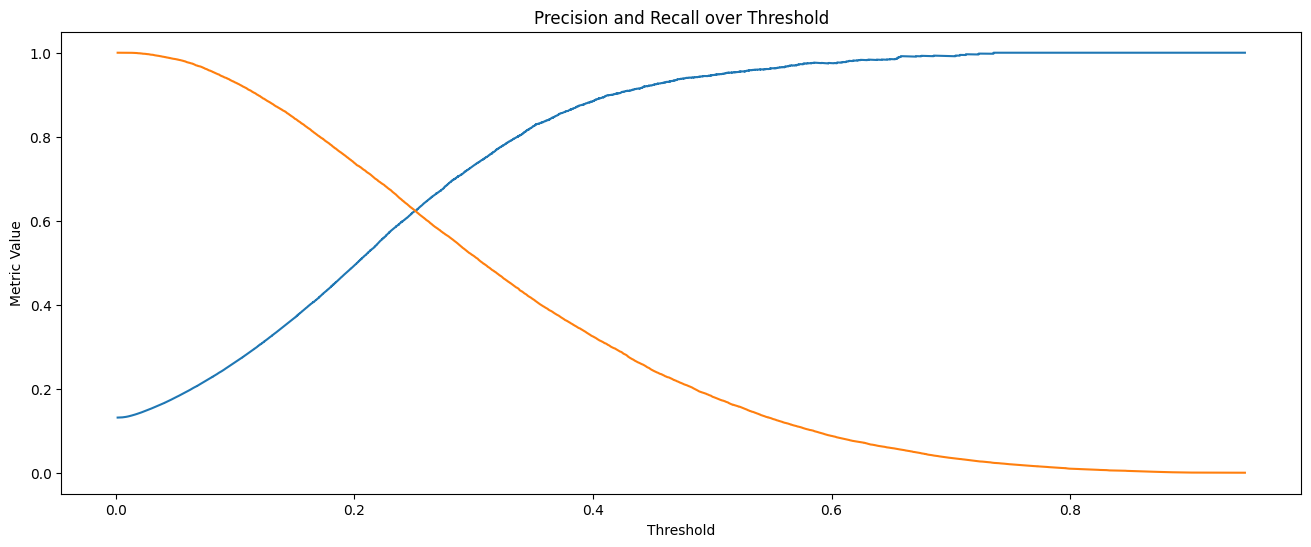

In [223]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(labels.to_pandas(), y_hat)
plt.figure(figsize=(16, 6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.title('Precision and Recall over Threshold')

Optimal Threshold: 0.28093454241752625


Text(0, 0.5, 'Precision')

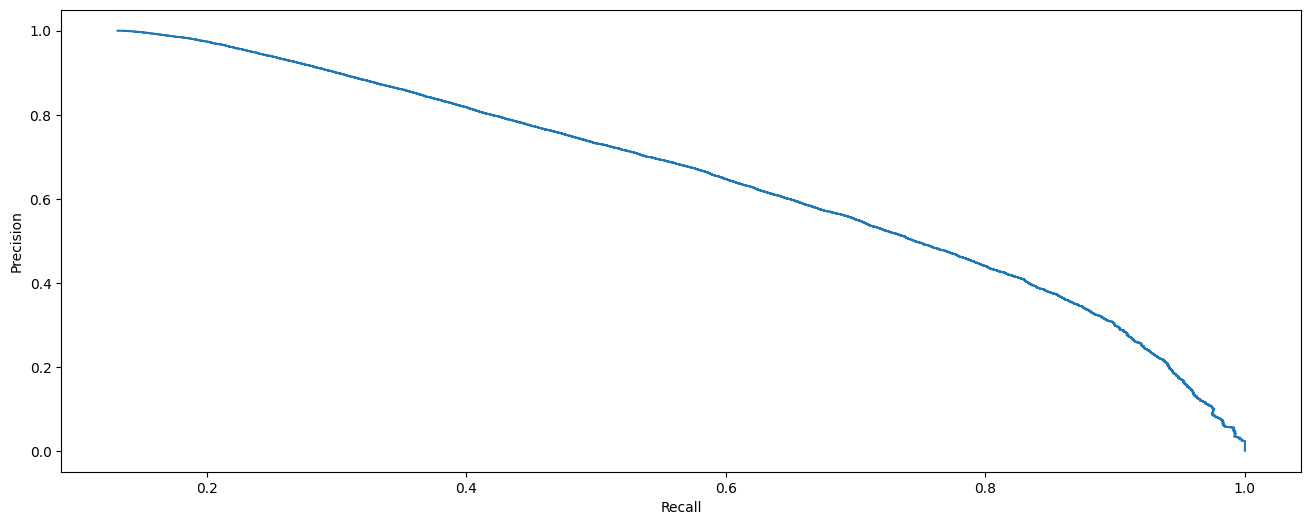

In [224]:
# get the threshold that maximizes the sum of precision and recall
optimal_threshold = thresholds[np.argmax(precision[:-1] + recall[:-1])]
print(f"Optimal Threshold: {optimal_threshold}")

# plot the precision and recall at the optimal threshold
plt.figure(figsize=(16, 6))
plt.plot(precision[:-1], recall[:-1], label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')


In [225]:
from sklearn.metrics import confusion_matrix
print("TP: ",labels.sum())
confusion_matrix(labels.to_pandas(), np.where(y_hat > optimal_threshold, 1, 0))

TP:  shape: (1, 1)
┌─────────────┐
│ long_signal │
│ ---         │
│ i64         │
╞═════════════╡
│ 17526       │
└─────────────┘


array([[111573,   4329],
       [  7734,   9792]])

In [226]:
confusion_matrix(labels.to_pandas(), np.where(y_hat >= optimal_threshold, 1, 0), normalize='true')

array([[0.96264948, 0.03735052],
       [0.44123017, 0.55876983]])

# NEXT STEP:
# 1) split train validation test set
# 2) rafforzare la cross validation
# 3) backtestare strategia

In [297]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt

def backtest_strategy(
    df: pl.DataFrame,
    # start_date: pl.Datetime,
    # end_date: pl.Datetime,
    signal_column: str = "long_signal",
    pred_column: str = "y_hat",
    investment_amount: int = 1000,
    rr_ratio: int = 2,
    optimal_threshold: float = 0.5
):

    # Filter the dataframe for the specified date range
    # df_backtest = df.filter((pl.col('timestamp') >= start_date) & (pl.col('timestamp') <= end_date))
    df_backtest = df
    # Initialize portfolio value and position
    initial_balance = investment_amount
    pct_profit = .01 * rr_ratio
    pct_loss = -pct_profit / rr_ratio
    
    # Calculate position changes
    # df_backtest = df_backtest.with_columns([
    #     pl.when((pl.col(signal_column) == 1) & (pl.col(pred_column) >= optimal_threshold))
    #     .then(investment_amount / pl.col('close'))
    #     .otherwise(0).alias('position_change'),
    #     
    #     pl.when((pl.col(signal_column) == -1) & (pl.col(pred_column) < optimal_threshold))
    #     .then(-1)
    #     .otherwise(0).alias('close_position')
    # ])

    position_return = initial_balance * pl.col("pct_return")
    compound_balance = initial_balance * (1 + pl.col("pct_return")).cum_prod()
    df_backtest = df_backtest.with_columns(
        pl.when((pl.col(pred_column) == 1) & (pl.col(signal_column) == 1))
        .then(pct_profit)
        .when((pl.col(pred_column) == 1) & (pl.col(signal_column) == 0))
        .then(pct_loss)
        .otherwise(0)
        .alias("pct_return"),
    ).with_columns(
        (position_return).alias("position_return"),
        (initial_balance + position_return.cum_sum()).alias("balance"),
        (pl.col("pct_return") * compound_balance.shift(1).fill_null(initial_balance)).alias("compound_position_return"),
        (compound_balance).alias("compound_balance")
    )

    # Calculate returns
    df_backtest = df_backtest.with_columns([
        pl.col('balance').pct_change().alias('return')
    ])

 
    # Extract results
    portfolio_values = df_backtest['balance'].to_list()
    returns = df_backtest['balance'].drop_nulls().to_list()
    
    # Calculate metrics
    total_return = (portfolio_values[-1] - initial_balance) / initial_balance
    sharpe_ratio = np.mean(returns) / np.std(returns) * np.sqrt(365)  # Assuming 365 trading days in a year

    print(f"Total Return: {total_return:.2%}")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

    return df_backtest
    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
    
    # Portfolio value over time
    ax1.plot(df_backtest['date'], portfolio_values)
    ax1.set_title('Portfolio Value Over Time')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Portfolio Value ($)')
    
    # Returns distribution
    ax2.hist(returns, bins=50)
    ax2.set_title('Distribution of Returns')
    ax2.set_xlabel('Return')
    ax2.set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

    
    return portfolio_values, returns

In [299]:
df_backtest = df_merged.with_columns(
    y_hat = pl.lit(np.where(y_hat >= optimal_threshold, 1, 0))
).select(pl.col("date"), pl.col("symbol"), pl.col("long_signal"), pl.col("y_hat"))


tmp = backtest_strategy(df_backtest)
tmp.tail()

Total Return: 15819.00%
Sharpe Ratio: 36.77


date,symbol,long_signal,y_hat,pct_return,position_return,balance,compound_position_return,compound_balance,return
datetime[μs],str,i8,i64,f64,f64,f64,f64,f64,f64
2024-09-29 07:00:00,"""LTC""",0,0,0.0,0.0,159190.0,0.0,5.9334e70,0.0
2024-09-29 08:00:00,"""LTC""",0,0,0.0,0.0,159190.0,0.0,5.9334e70,0.0
2024-09-29 09:00:00,"""LTC""",0,0,0.0,0.0,159190.0,0.0,5.9334e70,0.0
2024-09-29 10:00:00,"""LTC""",0,0,0.0,0.0,159190.0,0.0,5.9334e70,0.0
2024-09-29 11:00:00,"""LTC""",0,0,0.0,0.0,159190.0,0.0,5.9334e70,0.0


La funzione di backtesting cosi come è non va bene perchè:
1) indipendentemente dal calcolo cumulato o no del balance, tengo sempre in considerazione l'1% di rischio
   es ho 1000 usd, investo su btc, il bilancio diventerebbe 0. Quindi non potrei fare altri trade nel frattempo
2) se avessi più trade in parallelo, dovrei gestire il rischio cumulato e soprattutto dovrei partire con un budget maggiore
3) il bilancio finale che vedo sopra, cumulato o no, soffre del punto sopra

Si potrebbe gestire il tutto con una coda pari al numero di trade massimi che posso fare e di conseguenza l'importo max per ciascun trade che deve essere proporzionale al bilancio. Occorre gestire il caso in cui due trade devono essere fatti in parallelo.




In [296]:
tmp.group_by("date").agg(
    pl.col("balance").last(),
    pl.col("pct_return").sum()
)

date,balance,pct_return
datetime[μs],f64,f64
2023-02-15 02:00:00,1420.0,0.0
2023-11-02 11:00:00,6370.0,0.0
2024-05-04 16:00:00,9670.0,0.0
2023-01-06 07:00:00,13320.0,0.0
2023-09-03 14:00:00,5780.0,0.0
…,…,…
2024-06-29 22:00:00,10010.0,0.0
2023-03-31 10:00:00,2980.0,0.002222
2023-07-21 10:00:00,5050.0,-0.001111


In [295]:
tmp.with_columns(pl.col("date").dt.date().alias("ymd")).group_by("ymd").agg(
    pl.col("balance").first(),
    pl.col("pct_return").average()
)

ymd,balance,pct_return
date,f64,f64
2024-08-16,12120.0,0.000694
2023-03-20,2060.0,0.001574
2023-03-23,2300.0,0.006019
2024-09-06,12440.0,0.000972
2023-07-17,4570.0,0.000741
…,…,…
2023-10-11,5900.0,0.000093
2024-06-08,9950.0,0.0
2023-05-12,3840.0,0.0
